In [1]:
import numpy as np
from math import pi
import matplotlib
import matplotlib.pyplot as plt
import phasespace


In [2]:
def beta_l(q2, m):
    return ztf.sqrt(1-(4*ztf.square(m))/(q2))

In [3]:
def spatial_sp(p1, p2):
    
    val=p1[0]*p2[0]+p1[1]*p2[1]+p1[2]*p2[2]
    
    return val

In [4]:
def sp(p1, p2):
    
    val0 = p1[3]*p2[3]
    
    val = spatial_sp(p1, p2)
    
    sp = val0 - val
    
    return sp

In [5]:
def get_costheta_l(p1, p2):  
    
    num = spatial_sp(p1, p2)
    
    den1= ztf.sqrt(spatial_sp(p1, p1))
    den2= ztf.sqrt(spatial_sp(p2, p2))
    
    costheta_l = num/(den1*den2)
    
    return costheta_l

In [6]:
from phasespace import Particle
mZ = 80000.00
mmu = 105.3


el1 = Particle('l1', mmu)
el2 = Particle('l2', mmu)
Z = Particle('Z', mZ).set_children(el1, el2)

#weights, particles = B.generate(n_events=10000)
weights_np, particles_np = Z.generate(n_events=10000)

Instructions for updating:
Colocations handled automatically by placer.


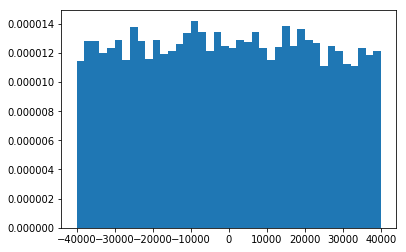

In [7]:
l1_X=particles_np['l1'][:,0];
l1_Y=particles_np['l1'][:,1];
l1_Z=particles_np['l1'][:,2];
l1_E=particles_np['l1'][:,3];

l2_X=particles_np['l2'][:,0];
l2_Y=particles_np['l2'][:,1];
l2_Z=particles_np['l2'][:,2];
l2_E=particles_np['l2'][:,3];

plt.hist(l1_X,bins=40, density=True);

In [8]:
((l1_X[:]+l2_X[:]).mean(), (l1_Y[:]+l2_Y[:]).mean(), (l1_Z[:]+l2_Z[:]).mean(), (l1_E[:]+l2_E[:]).mean())

(0.0, 0.0, 0.0, 80000.0)

In [9]:
import tensorflow as tf
import zfit

ztf = zfit.ztf
ztyping = zfit.util.ztyping
ztypes = zfit.settings.ztypes

/Users/davide/miniconda3/envs/zfit_env/lib/python3.6/site-packages/zfit/util/execution.py:57: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [10]:
class GaussianSampleAndWeights():

        def __call__(self, n_to_produce, limits, dtype):
            
            n_to_produce = tf.cast(n_to_produce, dtype=tf.int32)

            weights, phase_space_sample = Z.generate_tensor(n_events=n_to_produce) #check order 
            
            phase_space_sample_tensor = tf.concat([phase_space_sample["l1"],phase_space_sample["l2"]], axis=1)
            
            weights_max = None
            
            thresholds = tf.random_uniform(shape=(n_to_produce,), dtype=dtype)
            
            return phase_space_sample_tensor, thresholds, weights, weights_max, n_to_produce
        

In [11]:
class dGamma(zfit.pdf.ZPDF):
    
    #_PARAMS = ['ml']
    _PARAMS = []
    _N_OBS = 8

    def _unnormalized_pdf(self, x):
        
        #ml = self.params['ml']
        
        p1x, p1y, p1z, p1E, p2x, p2y, p2z, p2E =x.unstack_x()
        
        p1 = [p1x, p1y, p1z, p1E]
        p2 = [p2x, p2y, p2z, p2E]
        z = [0., 0., 1.]
        
        costheta_l= get_costheta_l(p1, z)
        #q2 = sp(p1+p2,p1+p2)

        pdf = (1+costheta_l+ztf.square(costheta_l))#*beta_l(q2, 0.)
        
        return pdf


In [12]:
#m_lepton = zfit.Parameter('ml', mmu)

In [13]:
upper_vec=np.sqrt(np.square(mZ)/4-np.square(mmu))
lower_vec=-np.sqrt(np.square(mZ)/4-np.square(mmu))

In [18]:
lower = ((lower_vec, lower_vec,  lower_vec,    0.,  lower_vec,  lower_vec,  lower_vec,   0.,  ),)
upper = ((upper_vec, upper_vec,  upper_vec, mZ/2,   upper_vec,  upper_vec,  upper_vec, mZ/2,  ),)

obs = zfit.Space(["p1x","p1y","p1z","p1E", "p2x","p2y", "p2z","p2E"], limits=(lower,upper))



In [19]:
pdf = dGamma(obs=obs)
#pdf = dGamma(obs=obs, ml = m_lepton)
pdf._sample_and_weights=GaussianSampleAndWeights

In [20]:
sampler = pdf.create_sampler(n=100000)

Instructions for updating:
Use tf.cast instead.


In [ ]:
for i in range(1):
    sampler.resample()
a=sampler.to_pandas()  

In [ ]:
plt.hist(a['p1z']/(mZ/2),bins=40);